# Appendix E

### E.1 Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from scipy.stats  import pearsonr
from datetime import *
import warnings
warnings.filterwarnings("ignore")

### E.2 Loading and Formatting Dataset

In [2]:
raw= pd.read_csv("raw_Formated_Data.csv").drop(["Unnamed: 0",'Time'],axis =1)
raw['Total'] = raw['CM'] + raw['WR']
raw['holidays'] = pd.Series ( np.where( raw.WR == -1, 1, 0 ) )
raw.date = pd.to_datetime(raw.date)
df = raw.fillna(method = 'backfill')


### E.3 Declaring Functions

In [3]:
#Function date_range
#inputs 
#end end date for range 
#start start date for range
#delta hourly change to take
#Ouputs range begginging at start range with delta increments in timestamps

def date_range(end, start, delta):
    change = timedelta(hours =delta)
    time = []
    curr = start
    while curr < end:
        time.append(curr)
        curr+= change
    return time

In [4]:
#Function Holiday
#inputs 
#day the specified day 
#data specified data to get holiday from
#delta end amount of days after holiday to stop tagging as holiday
#delta start how many days before holiday date to start flagging as holiday 
#outputs index in dataframe with holiday values 
def holiday(day,data,delta_end = 1,delta_start = 2 ):
    end_range = pd.Timestamp(day + timedelta(days = delta_end) )
  
    start_range =pd.Timestamp(day - timedelta(days = delta_start) )
   
    holidays =   pd.Series(np.where( ( (end_range > data.date) & ( start_range < data.date) ) ,1,0)  )
    index  =holidays.index[holidays ==1 ].tolist()
    return index

In [5]:
#function celcius 
#input F farenheit temperature value/s
#converts farenhait values to celcius 

def Celcius(F):
    return (F - 32) * 5.0/9.0

In [6]:
#function strip_preassure 
#input values 
#outputs numeric values 
def strip_preassure(val):
    return val.strip('in')

In [7]:
#function strip_precip 
#input values 
#outputs numeric values 
def strip_precip(val):
    return float(val.strip('in'))

In [8]:
#function F_strip 
#input values 
#outputs numeric values 
def F_strip(val):
    return Celcius(float(val.strip('F')) )

In [9]:
#function convert_to_percent 
#input values 
#outputs numeric values 
def convert_to_percent(val):
    return float(val.strip('%'))/100

In [10]:
#function strip_mph 
#input values 
#outputs numeric values 
def strip_mph(val):
    return float(val.strip('mph'))

In [11]:
#Function looper 
#column column to convert 
#fun specific function to use to convert 
#outputs column numeric values
#loops through a series of values and converts them into numeric values 
def looper(column, fun):
    j = 0
    for i in column:
       
        column[j] = fun(i)
        j+=1
    return column

In [12]:
#Holiday_appender  
#frame dataframe input
#fun specific function to use to convert 
#outputs column numeric values
#lAppends holiday column to specified dataframe with the holidays below  

def holiday_appender(frame):
    data = frame.copy()
    holi_list = []
    christmas = holiday(datetime(year = 2019,month =12,day = 19) ,data,18,0) 
    reading_week  = holiday(datetime(year = 2019,month =11,day = 4 ),data,7)  
    thanks_giving = holiday(datetime(year = 2019, month = 10, day = 14),data)
    reading_week_spring = holiday(datetime(year = 2020, month = 2, day = 15),data,7)
    holi_list.append( (christmas, thanks_giving  ,reading_week_spring,reading_week) )
    for i in holi_list[0]:
        for index in i:
            data.holidays[index] = 1 
    return data

In [13]:
#Function Filler 
#input df dataframe to be filled
#iterates throught dataframe filling missing values 
#if the rec is closed it will fill all values with zero 
#if the rec is open and there is a missing values it will fill the dataframe with the most recent valid entry
#operating hours are indicated by boolean statements weekend weekend_hour regular and regular_hour 


def filler(df):
    grouped = df.copy()
    for f,i in enumerate(grouped.Total.index):
        
        weekend =  (grouped.date[i].dayofweek ==  5 | grouped.date[i].dayofweek ==  4) 
        weekend_hour = (grouped.date[i].hour > 6 & grouped.date[i].hour <= 20 ) 
        regular =  (grouped.date[i].dayofweek !=  5 | grouped.date[i].dayofweek !=  4) 
        regular_hour = (grouped.date[i].hour > 6 & grouped.date[i].hour <= 23 ) 
        
        if(pd.isna(grouped.Total[i]) & (weekend) & (weekend_hour)):
           
            
            grouped.Temperature[i] = grouped.Temperature[i-1]
            grouped.Dew[i] = grouped.Dew[i-1]
            grouped.Humidity[i] = grouped.Humidity[i-1]
            grouped.WindSpeed[i] = grouped.WindSpeed[i-1]
            grouped.Pressure[i] = grouped.Pressure[i-1]
            grouped.Precip[i] = grouped.Precip[i-1]
            grouped.CM[i] = grouped.CM[i-1]
            grouped.WR[i] = grouped.WR[i-1]
            grouped.Total[i] = grouped.CM + grouped.WR
            
        elif(pd.isna(grouped.Total[i]) & (regular) & (regular_hour)):
           
            grouped.Total[i] = grouped.Total[i - 1]
            grouped.Temperature[i] = grouped.Temperature[i-1]
            grouped.Dew[i] = grouped.Dew[i-1]
            grouped.Humidity[i] = grouped.Humidity[i-1]
            grouped.WindSpeed[i] = grouped.WindSpeed[i-1]
            grouped.Pressure[i] = grouped.Pressure[i-1]
            grouped.Precip[i] = grouped.Precip[i-1]
            grouped.CM[i] = grouped.CM[i-1]
            grouped.WR[i] = grouped.WR[i-1]
            grouped.Total[i] = grouped.CM[i] + grouped.WR[i]
            
            
        elif(pd.isna(grouped.Total[i])):
          
            grouped.Total[i] = 0
            grouped.Total[i] = 0
            grouped.Temperature[i] = 0
            grouped.Dew[i] = 0
            grouped.Humidity[i] = 0
            grouped.WindSpeed[i] = 0
            grouped.Pressure[i] = 0
            grouped.Precip[i] = 0
            grouped.CM[i] = 0
            grouped.WR[i] = 0
            grouped.Total[i] = 0
            
    return grouped


### E.4 Object Conversion

In [14]:
#Converting traffic values to numeric

datetime_df = holiday_appender(df)
datetime_df.date = pd.to_datetime(datetime_df.date)
datetime_df.CM  = pd.to_numeric(datetime_df['CM'] )
datetime_df.WR = pd.to_numeric(datetime_df['WR'] )
datetime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3217 entries, 0 to 3216
Data columns (total 15 columns):
date           3217 non-null datetime64[ns]
tweets         3217 non-null object
CM             3217 non-null int64
WR             3217 non-null int64
Temperature    3217 non-null object
Dew            3217 non-null object
Humidity       3217 non-null object
Wind           3217 non-null object
WindSpeed      3217 non-null object
WindGust       3217 non-null object
Pressure       3217 non-null object
Precip         3217 non-null object
Condition      3217 non-null object
Total          3217 non-null int64
holidays       3217 non-null int32
dtypes: datetime64[ns](1), int32(1), int64(3), object(10)
memory usage: 364.6+ KB


The following lines of code are using the previous functions to convert string values in the dataframe to numeric values

In [15]:
datetime_df.Pressure = looper(datetime_df.Pressure, strip_preassure)
datetime_df.Pressure = pd.to_numeric(datetime_df['Pressure'] ) 


In [16]:
datetime_df.Dew = looper(datetime_df.Dew, F_strip)
datetime_df.Dew = pd.to_numeric(datetime_df['Dew'] ) 


In [17]:
datetime_df.Humidity = looper(datetime_df.Humidity, convert_to_percent)
datetime_df.Humidity = pd.to_numeric(datetime_df['Humidity'] ) 


In [18]:
datetime_df.Temperature = looper(datetime_df.Temperature,F_strip)
datetime_df.Temperature = pd.to_numeric(datetime_df['Temperature'] ) 


In [19]:
datetime_df.WindSpeed = looper(datetime_df.WindSpeed,strip_mph)
datetime_df.WindSpeed = pd.to_numeric(datetime_df['WindSpeed'] ) 


In [20]:
datetime_df.Precip = looper(datetime_df.Precip,strip_precip)
datetime_df.Precip = pd.to_numeric(datetime_df['Precip'] ) 


### E.5 Time Series Formatting

In [21]:
grouped= datetime_df.groupby(pd.Grouper(key = 'date' ,freq="H")).mean()
grouped = grouped.reset_index()


In [22]:
grouped

,date,CM,WR,Temperature,Dew,Humidity,WindSpeed,Pressure,Precip,Total,holidays
0,2019-09-29 12:00:00,17.000000,59.000000,13.888889,10.000000,0.77,13.0,29.39,0.0,76.0,0.0
1,2019-09-29 13:00:00,16.666667,61.333333,15.000000,8.888889,0.67,15.0,29.38,0.0,78.0,0.0
2,2019-09-29 14:00:00,12.000000,54.000000,15.000000,8.888889,0.67,18.0,29.35,0.0,66.0,0.0
3,2019-09-29 15:00:00,15.000000,52.000000,16.111111,7.777778,0.59,16.0,29.35,0.0,67.0,0.0
4,2019-09-29 16:00:00,21.000000,63.000000,16.111111,7.777778,0.59,16.0,29.35,0.0,84.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4032,2020-03-15 12:00:00,24.000000,48.000000,0.000000,-8.888889,0.51,8.0,29.60,0.0,72.0,0.0
4033,2020-03-15 13:00:00,22.000000,52.000000,0.000000,-8.888889,0.51,8.0,29.60,0.0,74.0,0.0
4034,2020-03-15 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4035,2020-03-15 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
#grouping data into hourly frequencies for constant time entries 

grouped= datetime_df.groupby(pd.Grouper(key = 'date' ,freq="H")).mean().round()
grouped = grouped.reset_index()

#converting data into a time series using date_range function 
time_series = date_range(grouped.date[len(grouped.date)-1],grouped.date[0],1)
time_df = pd.DataFrame({'date':time_series})
time_df = time_df.merge(grouped, left_on='date', right_on='date')


In [24]:
#using filler function to fill in missing values then using holiday function to fill in holiday column 

time_df = filler(time_df)
time_df['holidays'] = pd.Series ( np.where( time_df.WR == -1, 1, 0 ) )
time_df = holiday_appender(time_df)

In [25]:
#Creating closed column by specifying to when the total traffic equals zero 
time_df['closed'] = pd.Series( np.where( time_df.Total == 0, 1, 0 ) )
time_df['closedxholidays'] = pd.Series( np.where( (time_df.closed == 1) & (time_df.holidays == 1), 1, 0) ) 

### E.6 Dataset Splitting

In [26]:
#Creating date ordered training, testing and validation sets 
#Training corresponds to first 70% of observations
#validation set corresponds 15% of observations after training set
#test set consists of last 15% of observations

train_ts = time_df[:int(time_df.shape[0]*0.85)] 
test_ts = time_df[int(time_df.shape[0]*0.85):]
validation_ts = train_ts[int(train_ts.shape[0]*0.85):]
train_ts = train_ts[:int(train_ts.shape[0]*0.85) ]


train = datetime_df[int(datetime_df.shape[0]*0.15):]
test = datetime_df[:int(datetime_df.shape[0]*0.15)]


### E.7 Data Vizualization

Text(0.5, 0, 'Total Traffic')

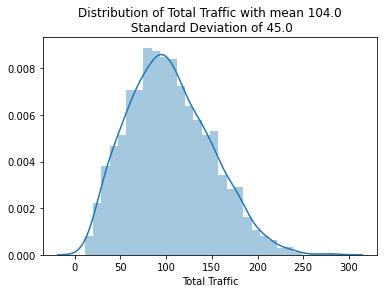

In [30]:
#Plotting distribution of rec centre traffic
ax = sns.distplot(train['Total'])
ax.set_title(f'Distribution of Total Traffic with mean {np.round(np.mean(train.Total))}\n Standard Deviation of {np.round(np.std(train.Total))}')
ax.set_xlabel('Total Traffic', fontsize=10)

Text(0.5, 32.99999999999995, 'Temperature Celcius')

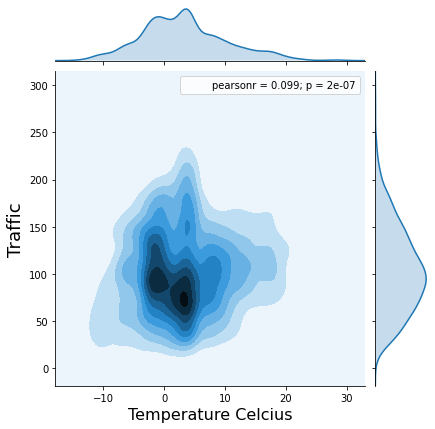

In [31]:
#plotting joint distribution of Temperature and Total 
ax = sns.jointplot(x = 'Temperature',y = 'Total',data = train, kind = 'kde', stat_func = pearsonr)
ax.ax_joint.set_ylabel('Traffic', fontsize=18)
ax.ax_joint.set_xlabel('Temperature Celcius', fontsize=16)

Text(0.5, 32.99999999999995, 'Humidity Percent')

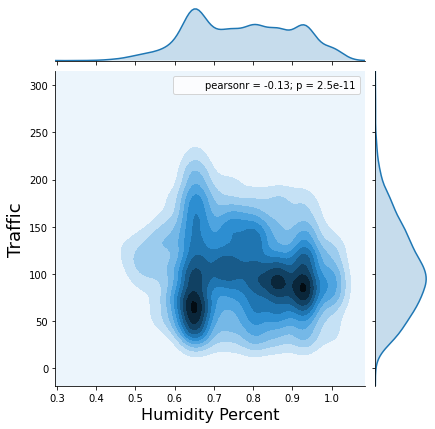

In [32]:
#plotting joint distribution of humidity and Total 
ax = sns.jointplot(x = 'Humidity',y = 'Total',data = train, kind = 'kde',stat_func = pearsonr)
ax.ax_joint.set_ylabel('Traffic', fontsize=18)
ax.ax_joint.set_xlabel('Humidity Percent', fontsize=16)

Text(0.5, 32.99999999999995, 'Wind Speed')

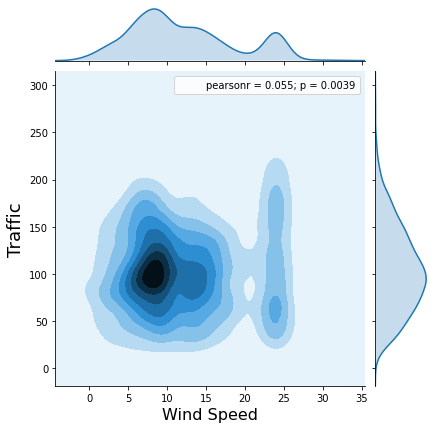

In [33]:
#plotting joint distribution of wind speed and Total 
ax = sns.jointplot(x = 'WindSpeed',y = 'Total',data = train, kind = 'kde', stat_func = pearsonr)
ax.ax_joint.set_ylabel('Traffic', fontsize=18)
ax.ax_joint.set_xlabel('Wind Speed', fontsize=16)

Text(0.5, 32.99999999999995, 'Pressure')

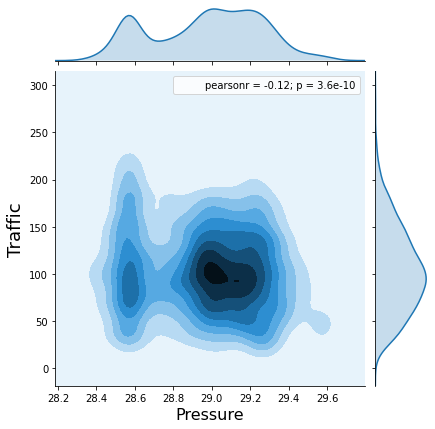

In [34]:
#plotting joint distribution of Pressure and Total 
ax = sns.jointplot(x = 'Pressure',y = 'Total',data = train, kind = 'kde',stat_func = pearsonr)
ax.ax_joint.set_ylabel('Traffic', fontsize=18)
ax.ax_joint.set_xlabel('Pressure', fontsize=16)


Text(0.5, 32.99999999999995, 'Cardio Mezzanine Traffic')

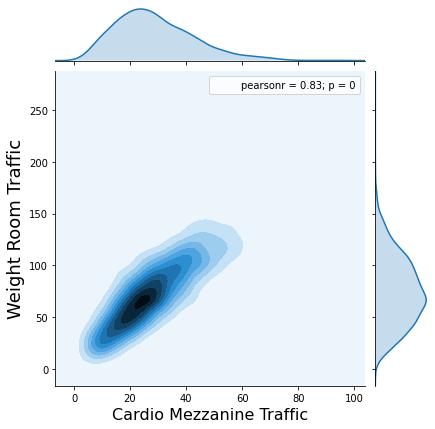

In [35]:
#plotting joint distribution of Temperature and Total 
ax = sns.jointplot(x = 'CM',y = 'WR',data = train, kind = 'kde',stat_func = pearsonr)
ax.ax_joint.set_ylabel('Weight Room Traffic', fontsize=18)
ax.ax_joint.set_xlabel('Cardio Mezzanine Traffic', fontsize=16)


Text(0.5, 0, 'Date')

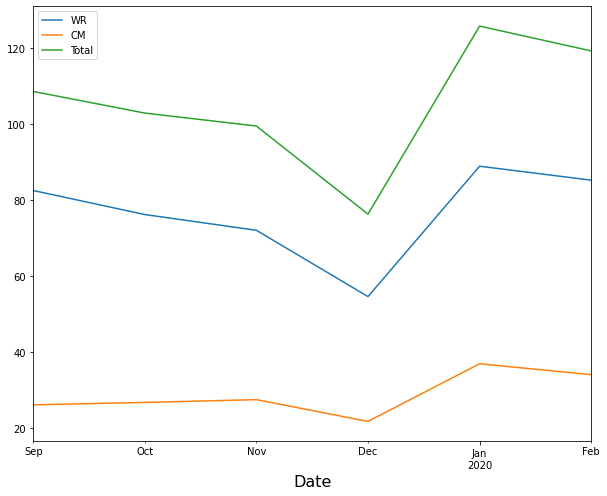

In [36]:
#plotting weight room cardio mezzanie and total traffic with monthly frequency averages
numbers = train[['WR','CM','Total','date']]

ax = numbers.groupby(pd.Grouper(key= 'date', freq="M")).mean().plot(figsize=(10,8))

ax.set_xlabel('Date', fontsize=16)

Text(0.5, 0, 'Date')

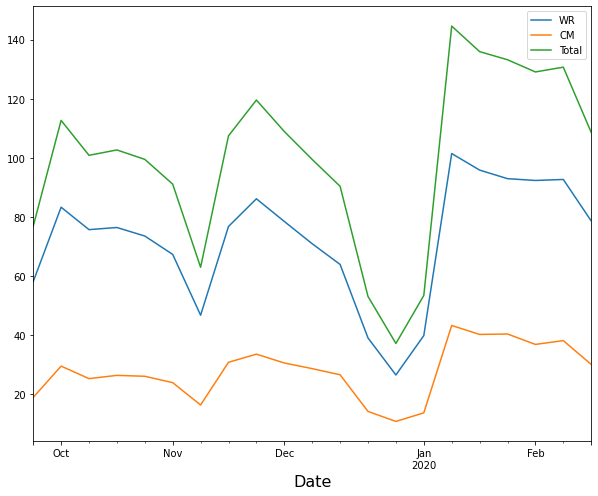

In [37]:
#plotting weight room cardio mezzanie and total traffic with weekly frequency averages
ax = numbers.groupby(pd.Grouper(key= 'date', freq="W")).mean().plot(figsize=(10,8))

ax.set_xlabel('Date', fontsize=16)

Text(0.5, 0, 'Date')

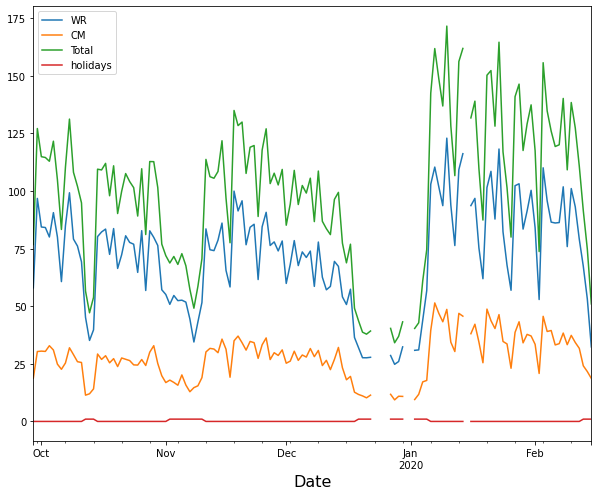

In [38]:
#plotting weight room cardio mezzanie and total traffic with hourly frequency averages
holi = train[['WR','CM','Total','date','holidays']]
ax = holi.groupby(pd.Grouper(key= 'date', freq="D")).mean().plot(figsize=(10,8))

ax.set_xlabel('Date', fontsize=16)


In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
#decomposing time series of total traffic with weekly hour (24*7 =168) frequency   
indexed = time_df.copy()
indexed = indexed.set_index('date')
result = seasonal_decompose(indexed.Total, model='additive',freq = 168)


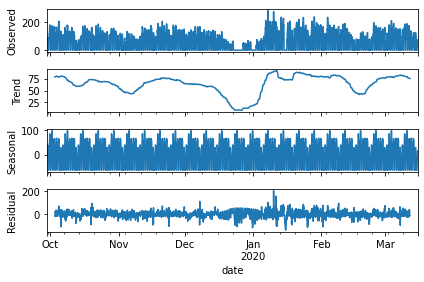

In [40]:
#plotting time series decomposition of total traffic
ax = result.plot()


### E.8 Data Exportation

In [41]:
data= train.drop('tweets',axis  = 1)
data.to_csv('train.csv')
train_ts.to_csv('train_ts.csv')

In [42]:
data_test= train.drop('tweets',axis  = 1)
data_test.to_csv('test.csv')
test_ts.to_csv('test_ts.csv')

In [43]:
validation_ts .to_csv('validation_ts.csv')